In [1]:
!pip install -U -q autogluon > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.13.0 requires aiohttp<4.0.0,>=3.9.2, but you have aiohttp 3.9.1 which is incompatible.
aiobotocore 2.13.0 requires botocore<1.34.107,>=1.34.70, but you have botocore 1.29.165 which is incompatible.
albumentations 1.4.0 requires scikit-image>=0.21.0, but you have scikit-image 0.20.0 which is incompatible.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import shutil

sns.set_style('white')
warnings.filterwarnings('ignore')

In [3]:
SEED = 27
TIME_LIMIT = 3600 * 10

# Loading and Processing the Datasets

In [4]:
train = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/train.csv')
test = pd.read_csv('/kaggle/input/rohlik-orders-forecasting-challenge/test.csv')

train = train[train.date >= "2022-01-01"]

test_ids = test['id'].values

train.shape, test.shape

((5286, 18), (397, 8))

In [5]:
missing_cols_in_test = [
    'shutdown',
    'mini_shutdown',
    'blackout',
    'mov_change',
    'frankfurt_shutdown',
    'precipitation',
    'snow',
    'user_activity_1',
    'user_activity_2'
]

train = train.drop(missing_cols_in_test, axis=1, errors='ignore')
train.shape, test.shape

((5286, 9), (397, 8))

In [6]:
train['is_train'] = 1
test['is_train'] = 0

combined = pd.concat([train, test], axis=0).reset_index(drop=True)

# Feature Engineering

In [7]:
def add_tfidf_features(df, ngram_range=(1, 2), max_features=50):
    df['holiday_name'] = df['holiday_name'].fillna('')

    vectorizer = TfidfVectorizer(
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        strip_accents='unicode',
        analyzer='word',
        ngram_range=ngram_range,
        sublinear_tf=True,
        max_features=max_features,
    )
    
    vectorized = vectorizer.fit_transform(df['holiday_name'])
    vectorized = vectorized.toarray()
    tfidf_df = pd.DataFrame(vectorized, columns=[f'tfidf_feat_{i}' for i in range(vectorized.shape[1])])
    return pd.concat([df, tfidf_df], axis=1)

In [8]:
def add_count_features(df, ngram_range=(1, 2), max_features=50):
    df['holiday_name'] = df['holiday_name'].fillna('')

    vectorizer = CountVectorizer(
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        strip_accents='unicode',
        analyzer='word',
        ngram_range=ngram_range,
        max_features=max_features,
    )
    
    vectorized = vectorizer.fit_transform(df['holiday_name'])
    vectorized = vectorized.toarray()
    cnt_df = pd.DataFrame(vectorized, columns=[f'cnt_feat_{i}' for i in range(vectorized.shape[1])])
    return pd.concat([df, cnt_df], axis=1)

In [9]:
def add_geo_features(df):
    country_city_mapping = {
        'Prague': 'Czech Republic',
        'Brno': 'Czech Republic',
        'Budapest': 'Hungary',
        'Munich': 'Germany',
        'Frankfurt': 'Germany'
    }

    df['city'] = df['warehouse'].str.split('_').str[0]
    df['country'] = df['city'].map(country_city_mapping)

    return pd.get_dummies(df, columns=['city', 'country'])

In [10]:
def add_time_features(df):    
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day'] = df['date'].dt.day
    df['sin_day'] = np.sin(2 * np.pi * df['day'] / 30)
    df['cos_day'] = np.cos(2 * np.pi * df['day'] / 30)
    df['day_of_week'] = df['date'].dt.dayofweek
    df['sin_day_of_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['cos_day_of_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_year'] = df['date'].dt.dayofyear
    df['sin_day_of_year'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['cos_day_of_year'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    df['week'] = df['date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['date'].dt.quarter
    df['season'] = (df['month'] % 12 + 3) // 3
    df['season'] = df['season'].astype(int)
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_friday'] = df['day_of_week'].isin([4]).astype(int)
    
    df['day_before_holiday'] = df['holiday'].shift().fillna(0)
    df['day_after_holiday'] = df['holiday'].shift(-1).fillna(0)
    df['day_before_school_holiday'] = df['school_holidays'].shift().fillna(0)
    df['day_after_school_holiday'] = df['school_holidays'].shift(-1).fillna(0)
    df['day_before_winter_school_holiday'] = df['winter_school_holidays'].shift().fillna(0)
    df['day_after_winter_school_holiday'] = df['winter_school_holidays'].shift(-1).fillna(0)
    df['holiday_and_shops_closed'] = df['holiday'] * df['shops_closed']

    return df

In [11]:
def convert_cat_features(df):
    return pd.get_dummies(df, columns=['warehouse', 'holiday_name'])

In [12]:
def drop_useless_features(train_df, test_df):
    X_mi = train.drop(['orders', 'id'], axis=1)
    y_mi = train['orders']
    
    mutual_info = mutual_info_regression(X_mi, y_mi, random_state=SEED)
    mutual_info = pd.Series(mutual_info)
    mutual_info.index = X_mi.columns
    mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Feature_MI'])
    
    useless_cols = []
    for col in mutual_info.index:
        if mutual_info.loc[col, 'Feature_MI'] <= 0:
            useless_cols.append(col)
            
    train_df = train_df.drop(useless_cols, axis=1, errors='ignore')
    test_df = test_df.drop(useless_cols, axis=1, errors='ignore')
    
    return train_df, test_df, useless_cols

In [13]:
def separate_train_test(df):
    train = df[df['is_train'] == 1].drop('is_train', axis=1)
    test = df[df['is_train'] == 0].drop(['is_train', 'orders'], axis=1)

    train = train.set_index('date').sort_index()
    test = test.set_index('date').sort_index()
    
    return train, test

In [14]:
combined = add_tfidf_features(combined)
combined = add_count_features(combined)
combined = add_geo_features(combined)
combined = add_time_features(combined)
combined = convert_cat_features(combined)
train, test = separate_train_test(combined)
train, test, useless_cols = drop_useless_features(train, test)

In [15]:
tfidf_cols = [col for col in train.columns if 'tfidf_feat' in col]
cnt_cols = [col for col in train.columns if 'cnt_feat' in col]

used_tfidf_features = len(tfidf_cols) - len(set(useless_cols) & set(tfidf_cols))
used_cnt_features = len(cnt_cols) - len(set(useless_cols) & set(cnt_cols))

print(f"Used TFIDF features: {used_tfidf_features}")
print(f"Used Count features: {used_cnt_features}")
print("\nTotal features:", train.shape[1])

Used TFIDF features: 36
Used Count features: 26

Total features: 118


# Preparing Data for AutoGluon

In [16]:
train['item_id'] = train['id'].apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1])
test['item_id'] = test['id'].apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1])

train = train.drop(columns=['id'])
test = test.drop(columns=['id'])

train = train.rename(columns={'orders': 'target'})
test['target'] = 0

train = train.reset_index(drop=False)
test = test.reset_index(drop=False)

In [17]:
train_data = TimeSeriesDataFrame.from_data_frame(train, id_column='item_id', timestamp_column='date')
test_data = TimeSeriesDataFrame.from_data_frame(test, id_column='item_id', timestamp_column='date')

train_data['is_train'] = True
test_data['is_train'] = False

combined = pd.concat([train_data, test_data])

combined = combined.convert_frequency(freq='D')
combined = combined.sort_index().fill_missing_values()

train_data = combined[combined.is_train == True]
test_data = combined[combined.is_train == False]

train_data = train_data.drop(columns=['is_train'])
test_data = test_data.drop(columns=['is_train'])

In [18]:
covariate_features = [col for col in train_data.columns if col not in ['target', 'item_id', 'date']]

# Training

In [19]:
quantile_levels = [0.4, 0.45, 0.5, 0.55, 0.6]

predictor = TimeSeriesPredictor(
    prediction_length=61,
    target='target',
    eval_metric='MAPE',
    known_covariates_names=covariate_features,
    quantile_levels=quantile_levels,
    freq='D'
)

predictor.fit(
    train_data,
    presets='best_quality',
    random_seed=SEED,
    time_limit=TIME_LIMIT
)

No path specified. Models will be saved in: "AutogluonModels/ag-20240702_062101"
Beginning AutoGluon training... Time limit = 36000s
AutoGluon will save models to 'AutogluonModels/ag-20240702_062101'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Dec 19 13:14:11 UTC 2023
CPU Count:          4
GPU Count:          1
Memory Avail:       29.95 GB / 31.36 GB (95.5%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAPE,
 'freq': 'D',
 'hyperparameters': 'default',
 'known_covariates_names': ['shops_closed',
                            'winter_school_holidays',
                            'school_holidays',
                            'tfidf_feat_0',
                            'tfidf_feat_1',
                            'tfidf_feat_3',
                 

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

	-0.0687       = Validation score (-MAPE)
	25.98   s     = Training runtime
	6.22    s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. Training for up to 11750.1s of the 35850.3s of remaining time.
	/opt/conda/lib/python3.10/site-packages/torchaudio/lib/libtorchaudio.so: undefined symbol: _ZNK5torch8autograd4Node4nameB5cxx11Ev
Training timeseries model DeepAR. Training for up to 17624.8s of the 35849.6s of remaining time.
	/opt/conda/lib/python3.10/site-packages/torchaudio/lib/libtorchaudio.so: undefined symbol: _ZNK5torch8autograd4Node4nameB5cxx11Ev
Training timeseries model PatchTST. Training for up to 35249.3s of the 35849.3s of remaining time.
	/opt/conda/lib/python3.10/site-packages/torchaudio/lib/libtorchaudio.so: undefined symbol: _ZNK5torch8autograd4Node4nameB5cxx11Ev
Fitting simple weighted ensemble.
	Ensemble weights: {'AutoETS': 0.11, 'Chronos[base]': 0.45, 'DirectTabular': 0.06, 'SeasonalNaive': 0.38}
	-0.0639       = Validation sc

In [20]:
predictor.leaderboard().style.background_gradient("RdYlGn", subset=['score_val'])

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.063866,9.842328,2.067021,9
1,Chronos[base],-0.068685,6.220404,25.982623,8
2,SeasonalNaive,-0.069710,0.042392,2.223025,1
3,AutoETS,-0.073479,3.069245,13.119558,6
4,DynamicOptimizedTheta,-0.079236,1.243843,20.709421,5
5,AutoARIMA,-0.095606,5.969094,16.903476,7
6,CrostonSBA,-0.108665,0.046222,9.715671,3
7,DirectTabular,-0.154142,0.510287,16.846794,2
8,NPTS,-0.195382,1.769613,1.758266,4


# Making Predictions

In [21]:
predictions = predictor.predict(
    train_data,
    known_covariates=test_data[covariate_features]
)
predictions.to_csv("raw_predictions.csv")
predictions

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean          0.4         0.45          0.5  \
item_id  timestamp                                                        
Brno_1   2024-03-16  9323.428854  9180.935231  9252.555068  9323.428854   
         2024-03-17  8333.290421  8196.087528  8257.335543  8333.290421   
         2024-03-18  8282.345813  8113.397366  8206.055739  8282.345813   
         2024-03-19  8613.787586  8455.353069  8546.653052  8613.787586   
         2024-03-20  8495.104931  8342.589388  8425.776097  8495.104931   
...                          ...          ...          ...          ...   
Prague_3 2024-05-11  5456.560618  5225.654389  5341.139379  5456.560618   
         2024-05-12  5265.642358  5025.751339  5150.716921  5265.642358   
         2024-05-13  5074.941110  4844.362455  4967.167221  5074.941110   
         2024-05-14  4973.318518  4740.421895  4856.910034  4973.318518   
         2024-05-15  4903.953132  4653.786223  4770.602963  4903.953132   

                            0.55          0.6  
item_id  timestamp                             
Brno_1   2024-03-16  9405.938429  9491.779787  
         2024-03-17  8409.245300  8470.493137  
         2024-03-18  8347.000096  8415.094200  
         2024-03-19  8669.286529  8736.022310  
         2024-03-20  8564.433766  8647.620652  
...                          ...          ...  
Prague_3 2024-05-11  5586.938321  5727.350751  
         2024-05-12  5380.567695  5518.827879  
         2024-05-13  5197.671463  5332.109034  
         2024-05-14  5089.727002  5199.567823  
         2024-05-15  5044.781532  5164.091016  

[427 rows x 6 columns]

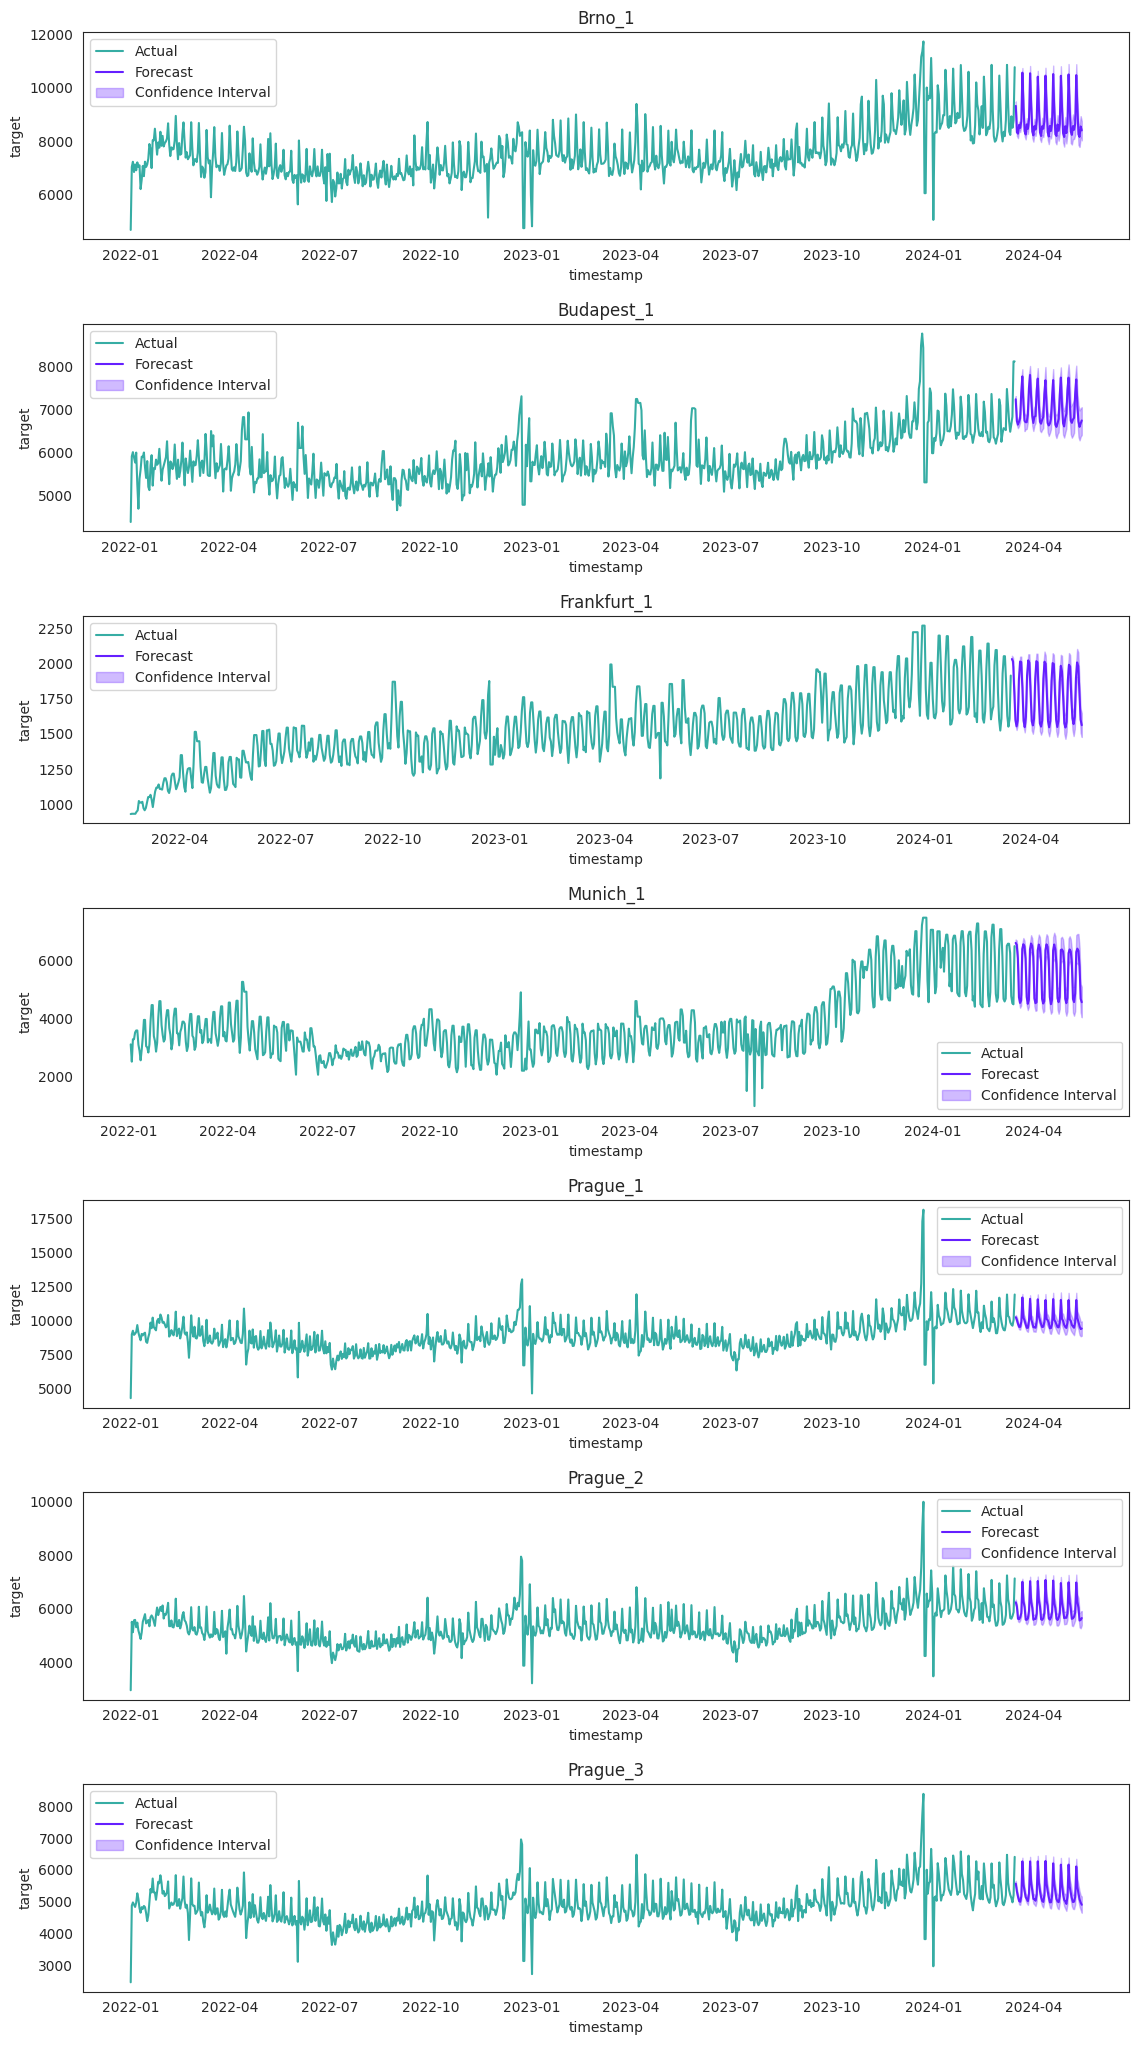

In [22]:
unique_item_ids = predictions['item_id'].unique() if 'item_id' in predictions.columns else predictions.index.get_level_values('item_id').unique()

nrows = len(unique_item_ids)
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
fig.tight_layout(pad=4.0)

if nrows == 1:
    axes = [axes]

for index, item_id in enumerate(unique_item_ids):
    ax = axes[index]
    actual_data = train_data.loc[(train_data.index.get_level_values('item_id') == item_id)]
    forecast_data = predictions.loc[(predictions.index.get_level_values('item_id') == item_id)]

    sns.lineplot(x=actual_data.index.get_level_values('timestamp'), y='target', data=actual_data, ax=ax, label='Actual', color=sns.color_palette('husl')[3])
    sns.lineplot(x=forecast_data.index.get_level_values('timestamp'), y='mean', data=forecast_data, ax=ax, label='Forecast', color='#651FFF')

    lower_quantile = f'{quantile_levels[0]}'
    upper_quantile = f'{quantile_levels[-1]}'
    ax.fill_between(forecast_data.index.get_level_values('timestamp'), forecast_data[lower_quantile], forecast_data[upper_quantile], color='#651FFF', alpha=0.3, label='Confidence Interval')

    ax.set_title(item_id)
    ax.legend()

plt.show()

In [23]:
predictions = predictions.reset_index(drop=False)
predictions['timestamp'] = predictions['timestamp'].astype('str')
predictions['id'] = predictions['item_id'] + '_' + predictions['timestamp']

In [24]:
def get_prediction(row):
    return predictions[predictions['id'] == row['id']]["mean"].values[0]

sub = pd.DataFrame({'id': test_ids, 'orders': 0})
sub['orders'] = sub.apply(get_prediction, axis=1)
sub.to_csv(f'submission.csv', index=False)
sub.head()

,id,orders
0,Prague_1_2024-03-16,10250.508371
1,Prague_1_2024-03-17,10047.801972
2,Prague_1_2024-03-18,9758.062119
3,Prague_1_2024-03-19,9543.637166
4,Prague_1_2024-03-20,9541.863249


In [25]:
shutil.rmtree("AutogluonModels")